<a href="https://colab.research.google.com/github/ActionPace/DeepLearningTests/blob/master/Hub_with_Keras_tf2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Authors.

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Hub with Keras

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/hub_with_keras"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/hub_with_keras.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/hub_with_keras.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

[TensorFlow Hub](http://tensorflow.org/hub) is a way to share pretrained model components. See the [TensorFlow Module Hub](https://tfhub.dev/) for a searchable listing of pre-trained models.

This tutorial demonstrates:

1. How to use TensorFlow Hub with `tf.keras`.
1. How to do image classification using TensorFlow Hub.
1. How to do simple transfer learning.

## Setup

### Imports

In [1]:
!pip install -U tensorflow_hub
!pip install tf-nightly-gpu

Requirement already up-to-date: tensorflow_hub in /usr/local/lib/python3.6/dist-packages (0.4.0)
    100% |████████████████████████████████| 374.2MB 52kB/s 
    100% |████████████████████████████████| 61kB 27.2MB/s 
    100% |████████████████████████████████| 3.1MB 9.3MB/s 
    100% |████████████████████████████████| 481kB 6.0MB/s 
  Stored in directory: /root/.cache/pip/wheels/89/67/41/63cbf0f6ac0a6156588b9587be4db5565f8c6d8ccef98202fc
Successfully built wrapt
thinc 6.12.1 has requirement wrapt<1.11.0,>=1.10.0, but you'll have wrapt 1.11.1 which is incompatible.
  Found existing installation: wrapt 1.10.11
    Uninstalling wrapt-1.10.11:
      Successfully uninstalled wrapt-1.10.11


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pylab as plt

import tensorflow as tf
tf.enable_eager_execution()

In [0]:
import tensorflow_hub as hub

from tensorflow.keras import layers

## An ImageNet classifier

### Download the classifier

Use `hub.module` to load a mobilenet, and `tf.keras.layers.Lambda` to wrap it up as a keras layer.

Any [tf2 compatible image classifier url from tfhub.dev](https://tfhub.dev/s?q=tf2&module-type=image-classification) will work here.

In [0]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" #@param {type:"string"}

In [0]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

### Run it on a single image

Download a single image to try the model on.

65536/61306 [================================] - 0s 0us/step


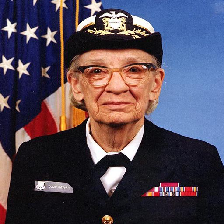

In [6]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [7]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

Add a batch dimension, and pass the image to the model.

In [8]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

The result is a 1001 element vector of logits, rating the probability of each class for the image.

So the top class ID can be found with argmax:

In [9]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

### Decode the predictions

We have the predicted class ID,
Fetch the `ImageNet` labels, and decode the predictions

In [10]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

16384/10484 [==============================================] - 0s 0us/step


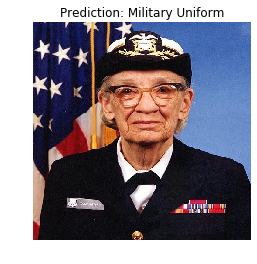

In [11]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

## Simple transfer learning

Using TF Hub it is simple to retrain the top layer of the model to recognize the classes in our dataset.

### Dataset

 For this example you will use the TensorFlow flowers dataset:

In [12]:
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

228818944/228813984 [==============================] - 4s 0us/step


The simplest way to load this data into our model is using `tf.keras.preprocessing.image.ImageDataGenerator`,

All of TensorFlow Hub's image modules expect float inputs in the `[0, 1]` range. Use the `ImageDataGenerator`'s `rescale` parameter to achieve this.

The image size will be handled later.

In [13]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

Found 3670 images belonging to 5 classes.


The resulting object is an iterator that returns `image_batch, label_batch` pairs.

In [14]:
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Labe batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Labe batch shape:  (32, 5)


### Run the classifier on a batch of images

Now run the classifier on the image batch.

In [15]:
result_batch = classifier.predict(image_batch)
result_batch.shape

(32, 1001)

In [16]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['ant', 'daisy', 'bee', 'obelisk', 'ringlet', 'pot', 'stinkhorn',
       'jellyfish', 'coral fungus', 'vase', 'handkerchief', 'tray',
       'spider web', 'bee', "yellow lady's slipper", 'vase', 'cardoon',
       'sea urchin', 'picket fence', 'daisy', 'daisy', 'hip', 'rapeseed',
       'hair slide', 'daisy', 'hip', 'artichoke', 'broom', 'packet',
       'daisy', 'daisy', 'quill'], dtype='<U30')

Now check how these predictions line up with the images:

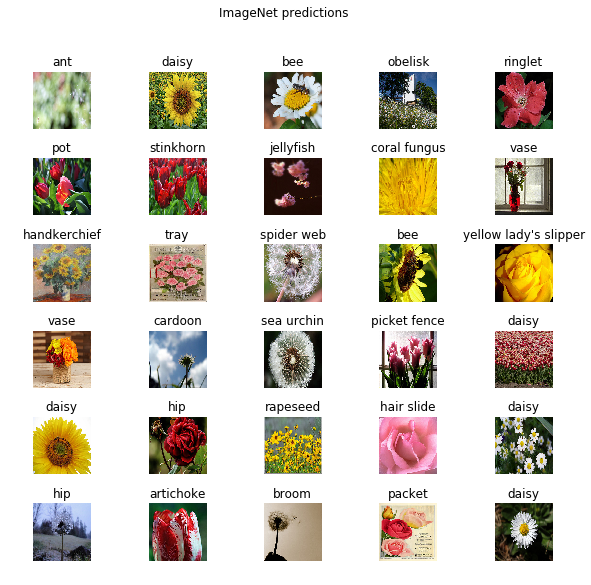

In [17]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

See the `LICENSE.txt` file for image attributions.

The results are far from perfect, but reasonable considering that these are not the classes the model was trained for (except "daisy").

### Download the headless model

TensorFlow Hub also distributes models without the top classification layer. These can be used to easily do transfer learning.

Any [image feature vector url from tfhub.dev](https://tfhub.dev/s?module-type=image-feature-vector&q=tf2) will work here.

In [0]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" #@param {type:"string"}

Create the module, and check the expected image size:

In [0]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

The feature extractor returns a 1280-element vector for each image.

In [20]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


Freeze the variables in the feature extractor layer, so that the training only modifies the new classifier layer.

In [0]:
feature_extractor_layer.trainable = False

### Attach a classification head

Now wrap the hub layer in a `tf.keras.Sequential` model, and add a new classification layer.

In [22]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(image_data.num_classes, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
predictions = model(image_batch)

In [24]:
predictions.shape

TensorShape([Dimension(32), Dimension(5)])

### Train the model

Use compile to configure the training process:

In [0]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

Now use the `.fit` method to train the model.

To keep this example short train just 2 epochs. To visualize the training progress, use a custom callback to log the loss and accuracy of each batch individually, instead of the epoch average.

In [0]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [27]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit(image_data, epochs=2,
                    steps_per_epoch=steps_per_epoch,
                    callbacks = [batch_stats_callback])

Epoch 1/2
115/115 [==============================] - 17s 149ms/step - loss: 0.8543 - acc: 0.8438
Epoch 2/2
115/115 [==============================] - 13s 117ms/step - loss: 0.5162 - acc: 0.9688


Now after, even just a few training iterations, we can already see that the model is making progress on the task.

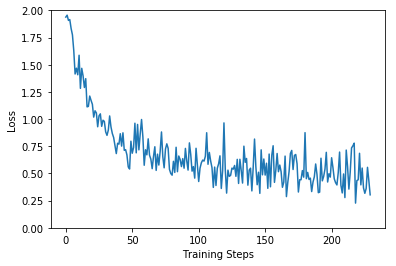

In [28]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

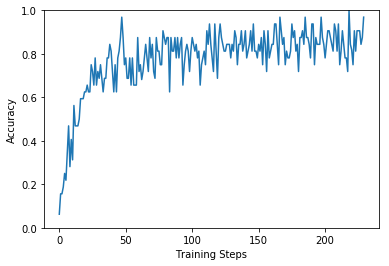

In [29]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

### Check the predictions

To redo the plot from before, first get the ordered list of class names:

In [30]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

Run the image batch through the model and convert the indices to class names.

In [0]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

Plot the result

In [0]:
label_id = np.argmax(label_batch, axis=-1)

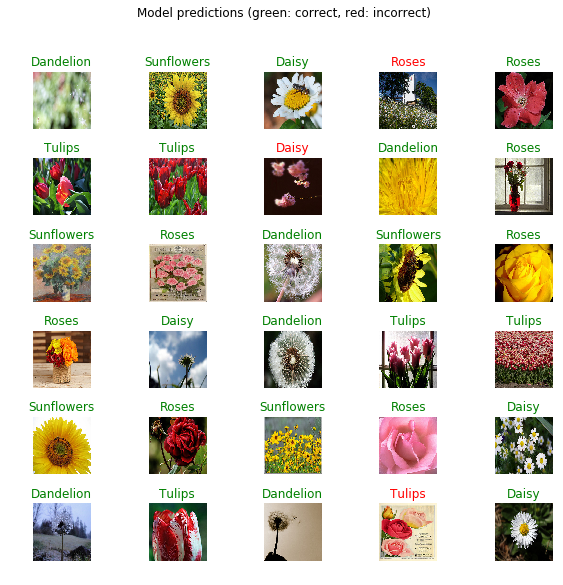

In [33]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

## Export your model

Now that you've trained the model, export it as a saved model:

In [34]:
import time
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
tf.keras.experimental.export_saved_model(model, export_path)

export_path

W0424 00:57:53.984777 139636994975616 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/saved_model/load.py:266: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0424 00:57:56.764164 139636994975616 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0424 00:57:56.845563 139636994975616 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with

'/tmp/saved_models/1556067472'

Now confirm that we can reload it, and it still gives the same results:

In [0]:
reloaded = tf.keras.experimental.load_from_saved_model(export_path, custom_objects={'KerasLayer':hub.KerasLayer})

In [0]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [37]:
abs(reloaded_result_batch - result_batch).max()

0.0

This saved model can loaded for inference later, or converted to [TFLite](https://www.tensorflow.org/lite/convert/) or [TFjs](https://github.com/tensorflow/tfjs-converter).

